Done:
* [X] get context embedding from reconstructed sound wave using Whisper encoder

Idea:
1. Input: has "wav" and "spec" keys. "wav" is for whisper in case we need, "spec" depends on the following:
  1. "noisy" is melspec from whisper as below
    * we can inject embed from whisper encoder into noisy
  1. "gt" is melspec in db we're using since we need to find method to convert from melspec back to wav
    * how to convert melspec to wav? check my [librosa-spectrogram.ipynb](https://drive.google.com/file/d/1oKID4qWy0pE35x_Pxsd8NodwIl9PT2Z6/view?usp=sharing)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install -U openai-whisper -q
!pip install datasets -q
!pip install librosa -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.9/792.9 kB 7.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 9.2 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

import soundfile as sf

import whisper
from datasets import load_dataset
import librosa
from IPython.display import Audio
from typing import Callable, Optional, Union
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
os.chdir('/content/gdrive/MyDrive/MSU/code/')

## support funcs

In [5]:
sample_rate = 16000
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128
n_stft = int((n_fft//2) + 1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class Clean:
    def __init__(self, device):
        self.sample_rate = 16000
        self.device = device
        self.max_len = 64000 + 1280

    def clean_signal(self, wav, sr):
        wav = self.resample_if_necessary(wav, sr)
        wav = self.mix_down_if_necessary(wav)
        wav = self.pad_or_trim(wav)
        return wav

    def mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    def resample_if_necessary(self, signal, sr):
        if sr != self.sample_rate:
            resampler = T.Resample(sr, self.sample_rate).to(self.device)
            signal = resampler(signal)
        return signal

    def pad_or_trim(self, signal):
        # cut_if_necessary
        signal = signal[:, :min(signal.shape[1], self.max_len)]  # cut by time axis
        # pad_if_necessary, pad with 0
        num_missing_samples = max(0, self.max_len - signal.shape[1])
        signal = torch.nn.functional.pad(signal, (0, num_missing_samples), value=0)
        return signal

In [6]:
def power_to_db(S, ref: Union[float, Callable] = 1.0, amin: float = 1e-10, top_db: Optional[float] = 80.0):
  # https://librosa.org/doc/latest/_modules/librosa/core/spectrum.html#power_to_db
  magnitude = S
  if callable(ref):
      # User supplied a function to calculate reference power
      ref_value = ref(magnitude)
  else:
      ref_value = torch.tensor(abs(ref))
  # log_spec: np.ndarray = 10.0 * np.log10(np.maximum(amin, magnitude))
  amin = torch.tensor(amin)
  log_spec = 10.0 * torch.log10(torch.maximum(amin, magnitude))
  log_spec -= 10.0 * torch.log10(torch.maximum(amin, ref_value))
  if top_db is not None:
    if top_db < 0: raise Exception("top_db must be non-negative")
    log_spec = torch.maximum(log_spec, log_spec.max() - top_db)
  # return log_spec ~= 10 * log10(S) - 10 * log10(ref)
  return log_spec

def db_to_power(S_db, ref: float = 1.0):
  # https://librosa.org/doc/latest/_modules/librosa/core/spectrum.html#db_to_power
  return ref * torch.pow(torch.tensor(10.), 0.1 * S_db)

def normalize_spec(melspec, minval=None, maxval=None):
  if (minval is None) and (maxval is None):
    maxval, minval = melspec.max(), melspec.min()
  melspec -= minval
  melspec /= (maxval - minval)
  return melspec, (minval, maxval)

def denormalize_spec(melspec, minval, maxval):
  melspec *= (maxval - minval)
  melspec += minval
  return melspec

def plot_waveform(waveform, sr, title="Waveform"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1)
    axes.plot(time_axis, waveform[0], linewidth=1)
    axes.grid(True)
    figure.suptitle(title)
    plt.show(block=False)

def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(specgram, origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [7]:
mel_transform = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode='reflect',
    power=2.0,
    normalized=True,
    norm="slaney",
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk"
).to(device)

invers_transform = T.InverseMelScale(
    sample_rate=sample_rate,
    n_stft=n_stft,
    n_mels=n_mels,
    mel_scale='htk',
    max_iter=1000
).to(device)

grifflim_transform = T.GriffinLim(n_fft=n_fft, win_length=win_length, power=2.0).to(device)

def whisper_log_mel_spectrogram(audio, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length):
    # https://github.com/openai/whisper/blob/main/whisper/audio.py#L110
    n_fft = 400
    win_length = None
    hop_length = 160
    n_mels = 80
    sample_rate = 16000

    stft = torch.stft(audio, n_fft, hop_length, window=torch.hann_window(n_fft), return_complex=True)
    magnitudes = stft[..., :-1].abs() ** 2

    filters = librosa.filters.mel(sr=sample_rate, n_fft=n_fft, n_mels=n_mels)
    filters = torch.from_numpy(filters)
    mel_spec = filters @ magnitudes

    log_spec = torch.clamp(mel_spec, min=1e-10).log10()
    log_spec = torch.maximum(log_spec, log_spec.max() - 8.0)
    log_spec = (log_spec + 4.0) / 4.0
    return log_spec

/usr/local/lib/python3.10/dist-packages/torchaudio/transforms/_transforms.py:611: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


## whisper get embed

In [8]:
model = whisper.load_model("small").to(device)
model;

100%|███████████████████████████████████████| 461M/461M [00:04<00:00, 99.6MiB/s]


In [9]:
# torch.save(model.state_dict(), 'whisper_base.pt')

In [13]:
# whisper forward
audiofile = 'p226_001.wav'
wav, sr = torchaudio.load(audiofile)
wav_pad = whisper.pad_or_trim(wav)
mel = whisper_log_mel_spectrogram(torch.cat([wav_pad for _ in range(2)], dim=0))
mel = mel.to(device)
print(mel.shape, wav_pad.shape, torch.cat([wav_pad for _ in range(2)], dim=0).shape)

encoder = model.encoder
audio_embedding = encoder(mel) # ~ model.embed_audio(mel)
audio_embedding.shape

torch.Size([2, 80, 3000]) torch.Size([1, 480000]) torch.Size([2, 480000])


(torch.Size([2, 1500, 768]),
 torch.Size([2, 1500, 768]),
 tensor(0., device='cuda:0', grad_fn=<SumBackward0>))

## audio to melspec

In [6]:
audiofile = 'p226_001.wav'
audio = whisper.load_audio(audiofile) # == wav, sr = torchaudio.load(audiofile)
audio = torch.from_numpy(audio)
wav, sr = torchaudio.load(audiofile)
wav = wav[0]
assert (audio - wav).sum().item() == 0.0

In [ ]:
# load audio and pad/trim it to fit 30 seconds (480 000 datapoints)
# audio = whisper.pad_or_trim(audio)
# audio = torch.tensor(audio)
# audio.shape

torch.Size([480000])

### melspec to audio (reconstruct), test Whisper ability to get context from reconstructed spec

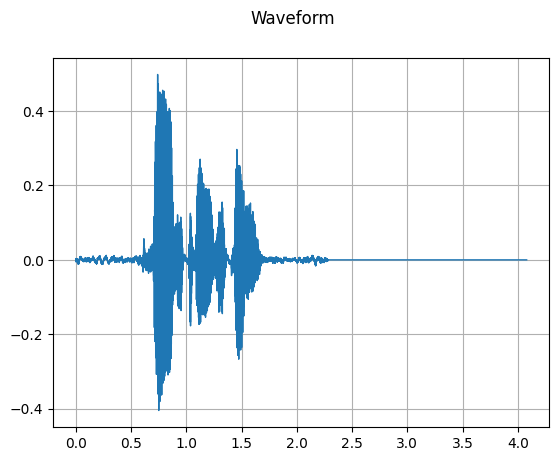

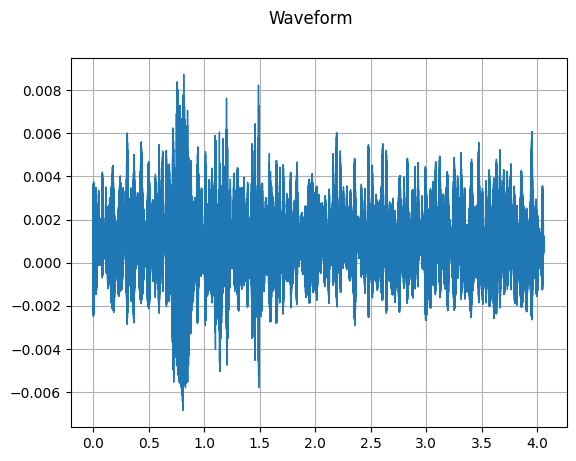

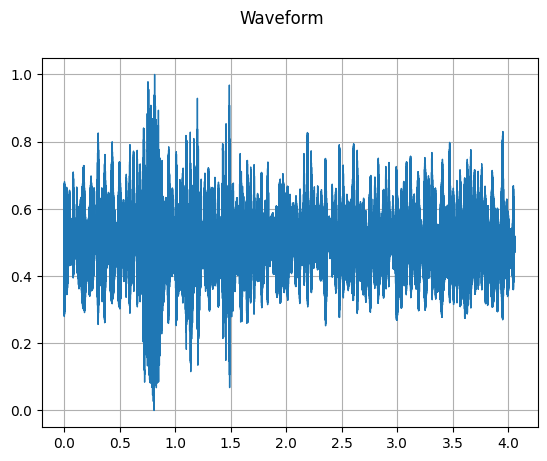

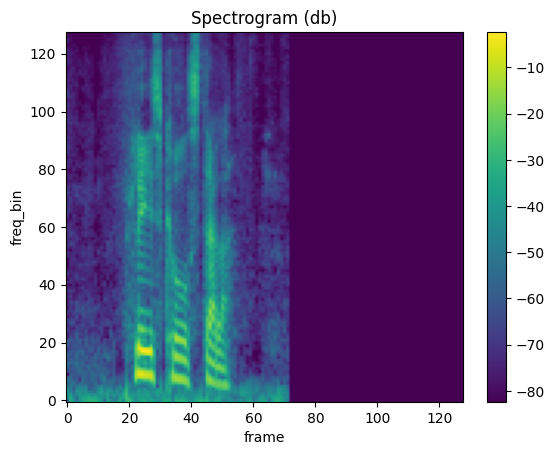

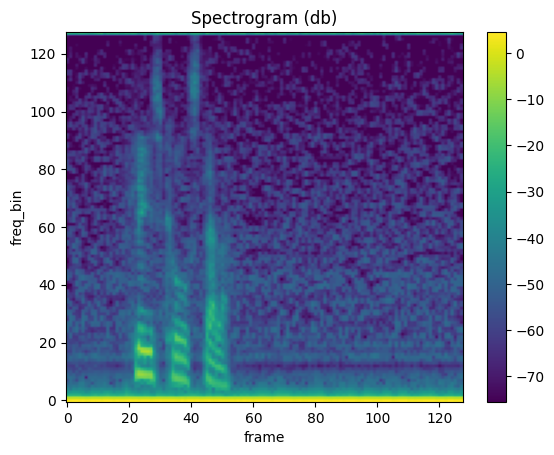

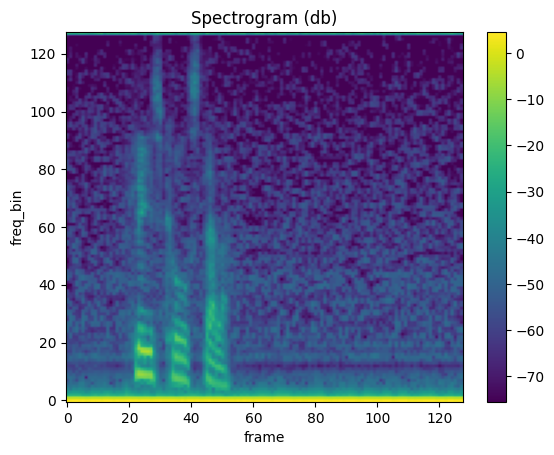

In [33]:
# original: https://drive.google.com/file/d/1oKID4qWy0pE35x_Pxsd8NodwIl9PT2Z6/view?usp=sharing
# TEST COMBINE
waveform, sample_rate = wav.detach().clone().unsqueeze(0), sr
waveform = waveform.to(device)

cleaner = Clean(device)
waveform = cleaner.clean_signal(waveform, sample_rate)

# audio to spec
mel_specgram = mel_transform(waveform)
# to db spec
mel_specgram_db = power_to_db(mel_specgram)
# normalize spec
mel_specgram_db_norm, minmaxval = normalize_spec(mel_specgram_db)
# clip range 0-1
mel_specgram_db_norm_clamp = torch.clamp(mel_specgram_db_norm, min=0.0, max=1.0)
assert (mel_specgram_db_norm == mel_specgram_db_norm_clamp).all().item()
# denormalize spec
mel_specgram_db_denorm = denormalize_spec(mel_specgram_db_norm_clamp, *minmaxval)
# spec to power
mel_specgram_db_denorm_depower = db_to_power(mel_specgram_db_denorm)
# spec to audio
pseudo_waveform_db_denorm = grifflim_transform(invers_transform(mel_specgram_db_denorm_depower))

plot_waveform(waveform.cpu(), sample_rate)
plot_waveform(pseudo_waveform_db_denorm.cpu(), sample_rate)
plot_waveform(normalize_spec(pseudo_waveform_db_denorm.cpu())[0], sample_rate)

plot_spectrogram(power_to_db(mel_transform(waveform)).cpu()[0])
plot_spectrogram(power_to_db(mel_transform(pseudo_waveform_db_denorm)).cpu()[0]) # ~ plot_spectrogram(power_to_db(mel_transform(normalize_spec(pseudo_waveform_db_denorm)[0])).cpu()[0])

Audio(pseudo_waveform_db_denorm.cpu(), rate=sample_rate)

In [12]:
# sf.write('z.wav', pseudo_waveform_db_denorm[0]*100, sample_rate, 'PCM_24')
torchaudio.save('z1.wav', pseudo_waveform_db_denorm*100, sample_rate)
print(pseudo_waveform_db_denorm.shape)
Audio('z1.wav')
# MOVE ON TO TRANSCRIBE TO SEE RESULT OF RECONSTRUCTED SPEC

torch.Size([1, 65024])


In [15]:
# make log-Mel spectrogram and move to the same device as the model
audio = pseudo_waveform_db_denorm.detach().clone()
mel = whisper.log_mel_spectrogram(audio)
mel1 = whisper_log_mel_spectrogram(audio)
assert (mel - mel1).sum().item() == 0.0
mel.shape, mel1.shape, mel.max()==mel1.max(), mel.min()==mel1.min()

(torch.Size([1, 80, 406]),
 torch.Size([1, 80, 406]),
 tensor(True),
 tensor(True))

## detect language

In [ ]:
# load audio and pad/trim it to fit 30 seconds
audio = whisper.load_audio(audiofile)
# audio = whisper.pad_or_trim(audio)
# audio = torch.from_numpy(audio)

In [ ]:
# load audio and pad/trim it to fit 30 seconds
audio = whisper.load_audio(audiofile)
audio = whisper.pad_or_trim(audio)

# make log-Mel spectrogram and move to the same device as the model
mel = whisper.log_mel_spectrogram(audio).to(model.device)

# detect the spoken language
_, probs = model.detect_language(mel)
print(f"Detected language: {max(probs, key=probs.get)}")

Detected language: en


In [ ]:
# decode the audio
options = whisper.DecodingOptions(fp16 = False) # fp16 = False when using cpu
result = whisper.decode(model, mel, options)
result

DecodingResult(audio_features=tensor([[-1.6867, -0.0313, -1.3046,  ..., -1.3794,  0.2935, -0.3698],
        [-1.0455,  0.1342, -0.2485,  ...,  0.3620,  0.0364,  0.7691],
        [-0.8170, -0.3631, -0.6112,  ...,  0.2940, -0.0347,  0.0457],
        ...,
        [-0.0854, -1.5159,  0.5505,  ...,  0.5463, -0.2726,  0.8265],
        [-0.6774, -1.3503,  0.3058,  ...,  0.2472,  0.2851,  0.1970],
        [-1.1805, -0.8160,  0.8670,  ...,  0.2264, -1.2621, -1.1197]]), language='en', language_probs=None, tokens=[50364, 2555, 818, 45073, 13, 50464], text='Please call Stella.', avg_logprob=-0.8306713104248047, no_speech_prob=0.10674966871738434, temperature=0.0, compression_ratio=0.7037037037037037)

## transcribe: model.transcribe("audio.mp3")

In [17]:
pseudo_waveform_db_denorm_padded = whisper.pad_or_trim(pseudo_waveform_db_denorm)
pseudo_mel = whisper_log_mel_spectrogram(pseudo_waveform_db_denorm_padded).to(model.device)
pseudo_mel.shape

torch.Size([1, 80, 3000])

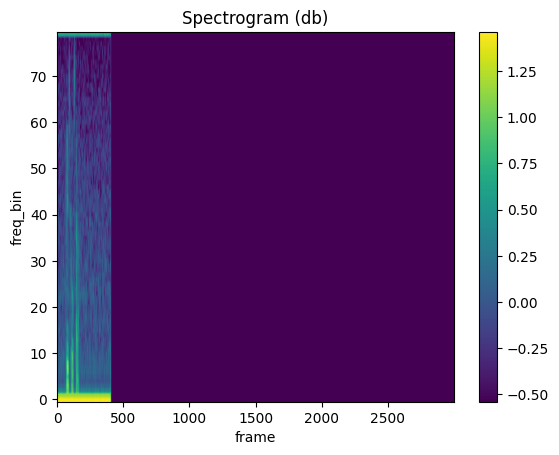

In [24]:
plot_spectrogram(pseudo_mel.cpu().numpy()[0])

In [27]:
result = model.transcribe('z1.wav')
result

/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:114: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


{'text': ' Please call Stella.',
 'segments': [{'id': 0,
   'seek': 0,
   'start': 0.0,
   'end': 2.0,
   'text': ' Please call Stella.',
   'tokens': [50364, 2555, 818, 45073, 13, 50464],
   'temperature': 0.0,
   'avg_logprob': -0.5349312169211251,
   'compression_ratio': 0.7037037037037037,
   'no_speech_prob': 0.051506660878658295}],
 'language': 'en'}

In [ ]:
def transcibe(model, audio):
  N_SAMPLES = 480000 # CHUNK_LENGTH * SAMPLE_RATE  # 480000 samples in a 30-second chunk
  N_FRAMES = 3000 # exact_div(N_SAMPLES, HOP_LENGTH)  # 3000 frames in a mel spectrogram input
  mel = whisper_log_mel_spectrogram(audio, padding=N_SAMPLES)
  content_frames = mel.shape[-1] - N_FRAMES # == 477000
